In [13]:
import geopandas as gp
import pandas as pd
import numpy as np
import os
import json
import urllib2
import pylab as pl
%pylab inline

from __future__ import print_function
__author__='djc'

s = json.load(open(os.getenv('PUI2015')+'/fbb_matplotlibrc.json'))
pl.rcParams.update(s)

Populating the interactive namespace from numpy and matplotlib


## data on energy consumption can be found here for the city of NY https://data.cityofnewyork.us/Environment/Energy-and-Water-Data-Disclosure-for-Local-Law-84-/rgfe-8y2z  

In [2]:
# download energy and water data set - this file is not too large and is saved in this directory on Github
nrg = gp.GeoDataFrame.from_csv("Energy_and_Water_Data_Disclosure_for_Local_Law_84__2013_.csv")
print (nrg.columns)

Index([u'NYC Borough, Block, and Lot (BBL)', u'Co-reported BBL Status',
       u'BBLs Co-reported',
       u'Reported NYC Building Identificaiton Numbers (BINs)',
       u'Street Number', u'Street Name', u'Borough', u'Zip Code',
       u'DOF Benchmarking Submission Status', u'Site EUI(kBtu/ft2)',
       u'Weather Normalized Site EUI(kBtu/ft2)', u'Source EUI(kBtu/ft2)',
       u'Weather Normalized Source EUI(kBtu/ft2)',
       u'Municipally Supplied Potable Water - Indoor Intensity (gal/ft²)',
       u'Automatic Water Benchmarking Eligible', u'Reported Water Method',
       u'ENERGY STAR Score', u'Total GHG Emissions(MtCO2e)',
       u'Direct GHG Emissions(MtCO2e)', u'Indirect GHG Emissions(MtCO2e)',
       u'Reported Property Floor Area (Building(s)) (ft²)',
       u'DOF Property Floor Area (Buildngs and Parking)(ft2)',
       u'Primary Property Type - Self Selected', u'DOF Number of Buildings'],
      dtype='object')


In [3]:
# from local directory - name is identical as what is provided
bsize = gp.GeoDataFrame.from_file("Manhattan/MNMapPLUTO.shp")
print (bsize.columns)

Index([    u'APPBBL',    u'APPDate',    u'Address', u'AllZoning1',
       u'AllZoning2', u'AreaSource', u'AssessLand',  u'AssessTot',
              u'BBL',   u'BldgArea',  u'BldgClass',  u'BldgDepth',
        u'BldgFront',      u'Block',   u'BoroCode',    u'Borough',
         u'BsmtCode',  u'BuiltCode',   u'BuiltFAR',     u'CB2010',
               u'CD',     u'CT2010',    u'ComArea',    u'CommFAR',
          u'CondoNo',    u'Council',  u'EDesigNum',  u'Easements',
       u'ExemptLand',  u'ExemptTot',        u'Ext',   u'FacilFAR',
       u'FactryArea',   u'FireComp', u'GarageArea', u'HealthArea',
         u'HistDist', u'IrrLotCode',    u'LandUse',   u'Landmark',
              u'Lot',    u'LotArea',   u'LotDepth',   u'LotFront',
          u'LotType',  u'LtdHeight', u'MAPPLUTO_F',   u'NumBldgs',
        u'NumFloors', u'OfficeArea',  u'OtherArea',   u'Overlay1',
         u'Overlay2',  u'OwnerName',  u'OwnerType', u'PLUTOMapID',
       u'PolicePrct',   u'ProxCode',    u'ResArea',   u'ResidF

In [4]:
def canconvert(mydata):
    try :
        float(mydata)
        return True
    except ValueError:
        return False

vfloat = np.vectorize(canconvert)

In [5]:
#create the indeces array here
indx_energy = vfloat(nrg['Site EUI(kBtu/ft2)'])
indx_area = vfloat(nrg['Reported Property Floor Area (Building(s)) (ft²)'])

In [6]:
nrg['Site EUI(kBtu/ft2)'][~indx_energy]=float('NaN')
nrg['Site EUI(kBtu/ft2)'][indx_energy]= nrg['Site EUI(kBtu/ft2)'].astype(float)
nrg['Reported Property Floor Area (Building(s)) (ft²)'][~indx_area]=float('NaN')
nrg['Reported Property Floor Area (Building(s)) (ft²)'][indx_area]=nrg['Reported Property Floor Area (Building(s)) (ft²)'].astype(float)

/Users/Daynan/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/Users/Daynan/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from IPython.kernel.zmq import kernelapp as app
/Users/Daynan/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instanc

In [7]:
nrg['BBL'] = nrg['NYC Borough, Block, and Lot (BBL)']
bblnrgbsize = pd.merge(nrg, bsize, on='BBL')
#print (bblnrgbsize.columns[0:50])

/Users/Daynan/anaconda/lib/python2.7/site-packages/pandas/core/index.py:1695: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  indexer = self._engine.get_indexer(target.values)
/Users/Daynan/anaconda/lib/python2.7/site-packages/pandas/core/index.py:1049: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  return key in self._engine


In [8]:
# only council district 3
bblnrgbsize = bblnrgbsize[bblnrgbsize['Council'] == 3]

# Drop all NaN's
bblnrgbsize_cut = bblnrgbsize.dropna(subset=['Site EUI(kBtu/ft2)','UnitsTotal','BBL','Reported Property Floor Area (Building(s)) (ft²)','YearBuilt','LandUse']).copy()

# total energy
bblnrgbsize_cut['totalEnergy'] = bblnrgbsize_cut['Site EUI(kBtu/ft2)']*bblnrgbsize_cut['Reported Property Floor Area (Building(s)) (ft²)']

# slice only columns needed for plotting
bblnrgbsize_cut = bblnrgbsize_cut[['Site EUI(kBtu/ft2)','UnitsTotal','Reported Property Floor Area (Building(s)) (ft²)','totalEnergy', 'BBL','YearBuilt', 'LandUse']].copy()

/Users/Daynan/anaconda/lib/python2.7/site-packages/pandas/core/index.py:1572: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  return self._engine.get_loc(_values_from_object(key))
/Users/Daynan/anaconda/lib/python2.7/site-packages/pandas/core/index.py:743: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  return self._engine.is_unique


In [9]:
# Cut outliers: 
# while some "properties" may include multiple bldgs,
# let's set remove records above a reasonable # of units/property or those with 0 units
bld_lim = 2501
cut2 = bblnrgbsize_cut[(bblnrgbsize_cut.UnitsTotal<bld_lim) & (bblnrgbsize_cut.UnitsTotal >0)]

# let's also remove anything below a low kBtu as misreported
e_lim = 1000
cut3 = cut2[cut2.totalEnergy>e_lim]

In [10]:
# land use categories 3=mf elevator, 4=mixed use, 5=commercial&office, 6=industrial
df_mf = bblnrgbsize_cut[(bblnrgbsize_cut['LandUse'] == '03')]
df_mu = bblnrgbsize_cut[(bblnrgbsize_cut['LandUse'] == '04')]
df_c = bblnrgbsize_cut[(bblnrgbsize_cut['LandUse'] == '05')]
df_i = bblnrgbsize_cut[(bblnrgbsize_cut['LandUse'] == '06')]

In [11]:
kelly_colors_hex = [
    '#FFB300', # Vivid Yellow
    '#803E75', # Strong Purple
    '#FF6800', # Vivid Orange
    '#A6BDD7', # Very Light Blue
    '#C10020', # Vivid Red
    '#CEA262', # Grayish Yellow
    '#817066', # Medium Gray
    '#007D34', # Vivid Green
    '#F6768E', # Strong Purplish Pink
    '#00538A', # Strong Blue
    '#FF7A5C', # Strong Yellowish Pink
    '#53377A', # Strong Violet
    '#FF8E00', # Vivid Orange Yellow
    '#B32851', # Strong Purplish Red
    '#F4C800', # Vivid Greenish Yellow
    '#7F180D', # Strong Reddish Brown
    '#93AA00', # Vivid Yellowish Green
    '#593315', # Deep Yellowish Brown
    '#F13A13', # Vivid Reddish Orange
    '#232C16', # Dark Olive Green
    ]

newparams = {
  "lines.linewidth": 2.0,
  "axes.edgecolor": "#aaaaaa",
  "patch.linewidth": 1.0,
  "legend.fancybox": 'false',
  "axes.color_cycle": kelly_colors_hex,
  "axes.facecolor": "#ffffff",
  "axes.labelsize": "large",
  "axes.grid": 'false',
  "patch.edgecolor": "#555555",
  "axes.titlesize": "x-large",
  "svg.embed_char_paths": "path",
}
pl.rcParams.update(newparams)

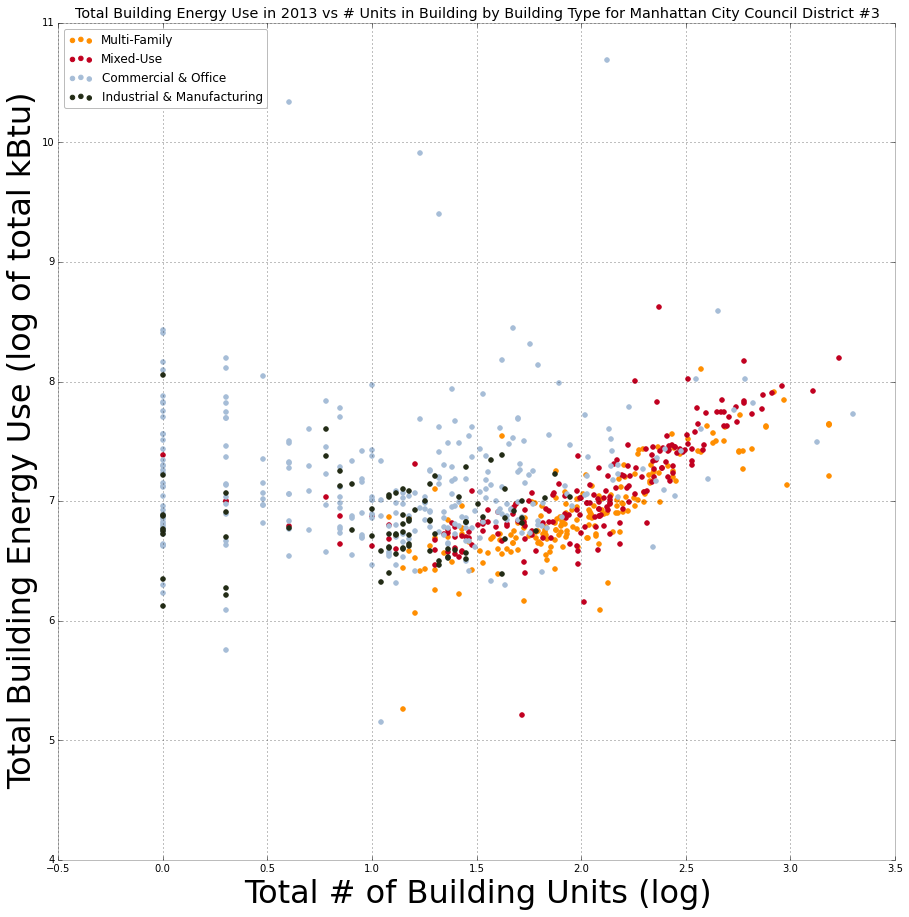

In [14]:
fig = pl.figure(figsize=(15,15))
pl.title('Total Building Energy Use in 2013 vs # Units in Building by Building Type for Manhattan City Council District #3')
pl.scatter(np.log10(list(df_mf.UnitsTotal)), np.log10(list(df_mf.totalEnergy)), color = '#FF8E00', label = 'Multi-Family', alpha = 1)
pl.scatter(np.log10(list(df_mu.UnitsTotal)), np.log10(list(df_mu.totalEnergy)), color = '#C10020', label = 'Mixed-Use', alpha = 1)
pl.scatter(np.log10(list(df_c.UnitsTotal)), np.log10(list(df_c.totalEnergy)), color = '#A6BDD7', label = 'Commercial & Office', alpha = 1)
pl.scatter(np.log10(list(df_i.UnitsTotal)), np.log10(list(df_i.totalEnergy)), color = '#232C16', label = 'Industrial & Manufacturing', alpha = 1)
pl.xlabel('Total # of Building Units (log)', size=32)
pl.ylabel('Total Building Energy Use (log of total kBtu)', size=32)
pl.legend(loc=2)